## _*H2 ground state energy computation using Quantum Phase Estimation*_

This notebook demonstrates using Qiskit Chemistry to compute ground state energy of the Hydrogen (H2) molecule using QPE (Quantum Phase Estimation) algorithm. Let's look at how to carry out such computation programmatically.

This notebook has been written to use the PYSCF chemistry driver.

### Step 1: Map problem to quantum circuits and operators

In [13]:
import numpy as np
import pyscf
from scipy.linalg import expm

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import OptimizerResult
from qiskit_algorithms import VQE
from qiskit_algorithms import PhaseEstimation

from qiskit.primitives import StatevectorSampler, Sampler
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService

We first set up the H2 molecule, create the fermionic and in turn the qubit operator using PySCF.

In [14]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735', basis='sto3g')
molecule = driver.run()
hamiltonian = molecule.hamiltonian.second_q_op()
mapper = ParityMapper(num_particles=molecule.num_particles)
tapered_mapper = molecule.get_tapered_mapper(mapper)
qubit_op = tapered_mapper.map(hamiltonian)

Using a classical exact eigenvalue solver, we can establish the reference groundtruth value of the ground state energy:

In [15]:
exact_eigensolver = NumPyMinimumEigensolver()
exact_eigensolver.filter_criterion = molecule.get_default_filter_criterion()
gse = GroundStateEigensolver(mapper, exact_eigensolver)
result = gse.solve(molecule)
print(f'The exact ground state energy is: {result.eigenvalues[0]} Ha')

The exact ground state energy is: -1.8572750302023788 Ha


Next we set up the QPE algorithm instance using the HartreeFock initial state:

In [16]:
qpe = PhaseEstimation(9, Sampler())

state_in = HartreeFock(molecule.num_spatial_orbitals, molecule.num_particles, tapered_mapper)
U = UnitaryGate(expm(1j*qubit_op.to_matrix()))

result = qpe.estimate(U, state_in)

print(f'Ground state energy from QPE: {(result.phase - 1) * 2*np.pi} Ha')

Ground state energy from QPE: -1.8530487917658545 Ha


/tmp/ipykernel_13556/874579480.py:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qpe = PhaseEstimation(9, Sampler())


As can be easily seen, the QPE computed energy is quite close to the groundtruth value we computed earlier.

### Step 2: Optimize for target hardware

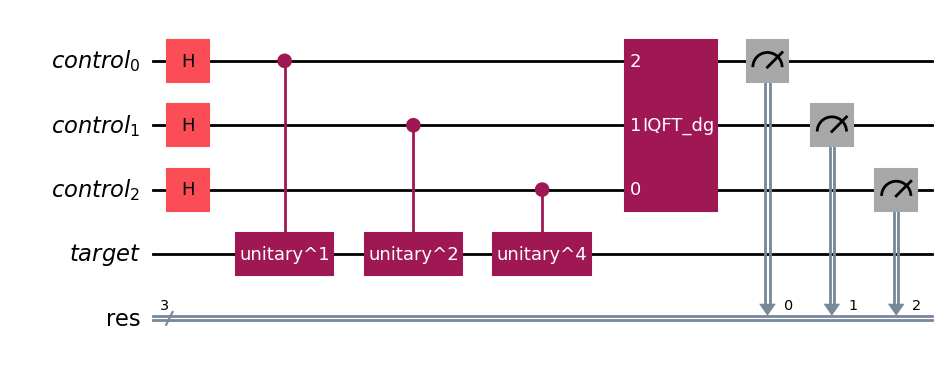

In [17]:
num_result_bits = 3
qpe = PhaseEstimation(num_result_bits, StatevectorSampler())

qr1 = QuantumRegister(num_result_bits, 'control')
qr2 = QuantumRegister(1, 'target')
cr = ClassicalRegister(num_result_bits, 'res')
circuit = QuantumCircuit(qr1, qr2, cr)
circuit.compose(qpe.construct_circuit(U, state_in), inplace=True)
circuit.measure(qr1, cr)
circuit.decompose().draw(output='mpl')

In [18]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

isa_circuit = pm.run(circuit)
isa_circuit.count_ops()

KeyboardInterrupt: 

### Step 3: Execute on target hardware

In [ ]:
sampler = SamplerV2(mode=backend)

job = sampler.run([isa_circuit])

result = job.result()
id = job.job_id()

print(id)

cz70aykkvm9g008gpgag


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
job = service.job(id)
job_result = job.result()

### Step 4: Post-process results

In [ ]:
""" best possible result using 3 bits:
phi = 0.c1c2c3 can be: 0 _ 0.125 _ 0.25 _ 0.375 _ ... _ 0.875
=> 2pi*(phi - 1) can be: ~ -6.28 _ -5.50 _ -4.71 _ ... _ -2.36 _ -1.57 _ -0.79 _ ... _ 0
So the closest result is -1.57, which corresponds to phi = 0.75 (= 0.110 in binary)
"""

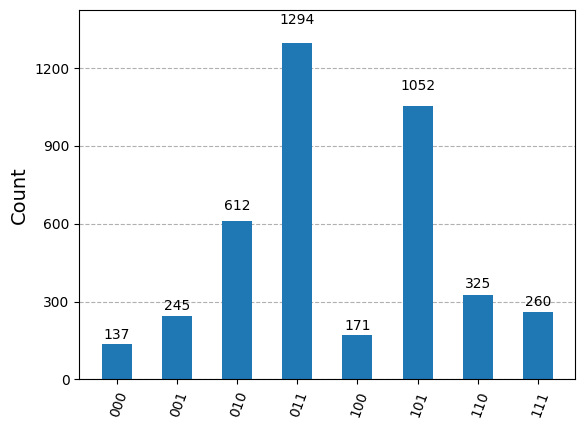

In [19]:
counts = job_result[0].data.res.get_counts()
plot_histogram(counts)

In [20]:
# get the most frequent result
max_key, max_value = max(counts.items(), key=lambda x: x[1])

phi = int(max_key[::-1], 2) / 8 # I have to reverse the string with this circuit because the first is the least significative bit, etc.
                                # in fact, if you look at the plot of the circuit used here: https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring#general-procedure-and-analysis
                                # you can see that the inverse QFT has the number in reverse order as the circuit here.
print(f'phi = {phi} => best approximation with 3 bits = {2*np.pi * (phi - 1):.2f} Ha')

phi = 0.75 => best approximation with 3 bits = -1.57 Ha


In [26]:
! pip freeze | grep qiskit

qiskit==1.1.0
qiskit-aer==0.14.2
qiskit-algorithms==0.3.0
qiskit-ibm-runtime==0.25.0
qiskit-machine-learning==0.7.2
qiskit-nature==0.7.2
qiskit-nature-pyscf==0.4.0
qiskit-qasm3-import==0.5.0
qiskit-transpiler-service==0.4.5
